In [17]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# from matplotlib_venn import venn3

# import heapq
import scipy.stats as stats

# import statsmodels.api as sm
# import matplotlib.ticker as mtick

# from statannot import add_stat_annotation

import pingouin as pg

# import plotly.express as px

matplotlib.rcParams['figure.dpi']= 300

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
annotation_df = pd.read_excel('../results/single-cell/saunders_2018/enhanced_annotation.xlsx',index_col='tissue_subcluster')
annotation_df.sort_index(axis=0,inplace=True)

In [3]:
# expression level in aggregated UMIs of each gene in each metacell
metacell_df = pd.read_csv('../data/single-cell/saunders_2018/metacells.BrainCellAtlas_Saunders_version_2018.04.01.csv', index_col=[0])

metacell_df.sort_index(axis=0,inplace=True)
metacell_df.sort_index(axis=1,inplace=True)

In [11]:
avg_dNdS_df=pd.read_csv('../results/Ensembl98_mouse/mouse.dNdS_stats.all_genes.tsv',sep='\t',usecols=['Gene name','mean'],index_col='Gene name')

avg_dNdS_df.rename(columns={'mean':'avg_dNdS'},inplace=True)

In [20]:
# excitatory neurons and inhibitory neurons subclusters 
exc_cluster_list=[]
inh_cluster_list=[]
both_exc_inh_list=[]
# non_neuronal_list=[]
for index, row in annotation_df.iterrows():
    if row['exc_inh']=='exc':
        exc_cluster_list.append(index)
    elif row['exc_inh']=='inh':
        inh_cluster_list.append(index)
    elif row['exc_inh']=='both':
        both_exc_inh_list.append(index)
    # elif row['exc_inh']=='Non-neuronal':
    #     non_neuronal_list.append(index)

In [21]:
print('Excitatory Neurons:')
exc_tot_exp = metacell_df[exc_cluster_list].to_numpy().sum()
print(exc_tot_exp)

print('Inhibitory Neurons:')
inh_tot_exp = metacell_df[inh_cluster_list].to_numpy().sum()
print(inh_tot_exp)

print('Both:')
both_exc_inh_tot_exp = metacell_df[both_exc_inh_list].to_numpy().sum()
print(both_exc_inh_tot_exp)

# print('Non-neuronal:')
# non_neuronal_tot_exp = metacell_df[non_neuronal_list].to_numpy().sum()
# print(non_neuronal_tot_exp)

Excitatory Neurons:
668760638
Inhibitory Neurons:
180468009
Both:
14155023


In [22]:
exc_inh_df = pd.DataFrame()

# 'UMI_per_Total_Excitatory_Expression'
exc_inh_df['exc']=metacell_df[exc_cluster_list].sum(axis=1)/exc_tot_exp
# UMI_per_Total_Inhibitory_Expression
exc_inh_df['inh']=metacell_df[inh_cluster_list].sum(axis=1)/inh_tot_exp
# UMI_per_Total_Both_Expression
exc_inh_df['both']=metacell_df[both_exc_inh_list].sum(axis=1)/both_exc_inh_tot_exp
# # UMI_per_Total_Non_Neuroanl_Expression
# exc_inh_df['nonN']=metacell_df[non_neuronal_list].sum(axis=1)/non_neuronal_tot_exp

In [33]:
exc_inh_df['exc_inh_assignment']='NA'
df = exc_inh_df
for i, row in df.iterrows():
    # if ((row['exc']>(row['inh']+row['both']+row['nonN'])) and (row['exc']>0.0001)):
    #     df.at[i,'exc_inh_assignment']='exc'
    # elif ((row['inh']>(row['exc']+row['both']+row['nonN'])) and (row['inh']>0.0001)):
    #     df.at[i,'exc_inh_assignment']='inh'
    # elif ((row['both']>(row['exc']+row['inh']+row['nonN'])) and (row['both']>0.0001)):
    #     df.at[i,'exc_inh_assignment']='both'
    # elif ((row['nonN']>(row['exc']+row['inh']+row['both'])) and (row['nonN']>0.0001)):
    #     df.at[i,'exc_inh_assignment']='nonN'
    if ((row['exc']>(row['inh']+row['both'])) and (row['exc']>0.0001)):
        df.at[i,'exc_inh_assignment']='exc'
    elif ((row['inh']>(row['exc']+row['both'])) and (row['inh']>0.0001)):
        df.at[i,'exc_inh_assignment']='inh'
    elif ((row['both']>(row['exc']+row['inh'])) and (row['both']>0.0001)):
        df.at[i,'exc_inh_assignment']='both'

In [34]:
print("--- When normalizing UMI counts to total expression ---")
print("Number of Excitatory Neuron-specific genes:")
df[df['exc_inh_assignment']=='exc'].shape[0]
print("Number of Inhibitory Neuron-specific genes:")
df[df['exc_inh_assignment']=='inh'].shape[0]
print("Number of Corelease Neruon-specific genes:")
df[df['exc_inh_assignment']=='both'].shape[0]
# print("Number of Non-Neruon-specific genes:")
# df[df['exc_inh_assignment']=='nonN'].shape[0]

--- When normalizing UMI counts to total expression ---
Number of Excitatory Neuron-specific genes:


185

Number of Inhibitory Neuron-specific genes:


154

Number of Corelease Neruon-specific genes:


154

In [35]:
exc_inh_merge_df = pd.merge(left=exc_inh_df,right=avg_dNdS_df,left_index=True,right_index=True,how="inner")

In [36]:
exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']=='exc'].shape
exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']=='inh'].shape
exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']=='both'].shape
# exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']=='nonN'].shape

(178, 5)

(152, 5)

(143, 5)

In [37]:
exc_arr=exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']=='exc']['avg_dNdS'].dropna().values
inh_arr=exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']=='inh']['avg_dNdS'].dropna().values
both_arr=exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']=='both']['avg_dNdS'].dropna().values
# nonN_arr=exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']=='nonN']['avg_dNdS'].dropna().values

Text(0.5, 0.98, 'Distribution of dN/dS of Mouse Excitatory, Inhibitory, and Corelease Neuron-specific Genes')

Text(0.5, 0, 'dN/dS')

Text(0, 0.5, 'number of genes')

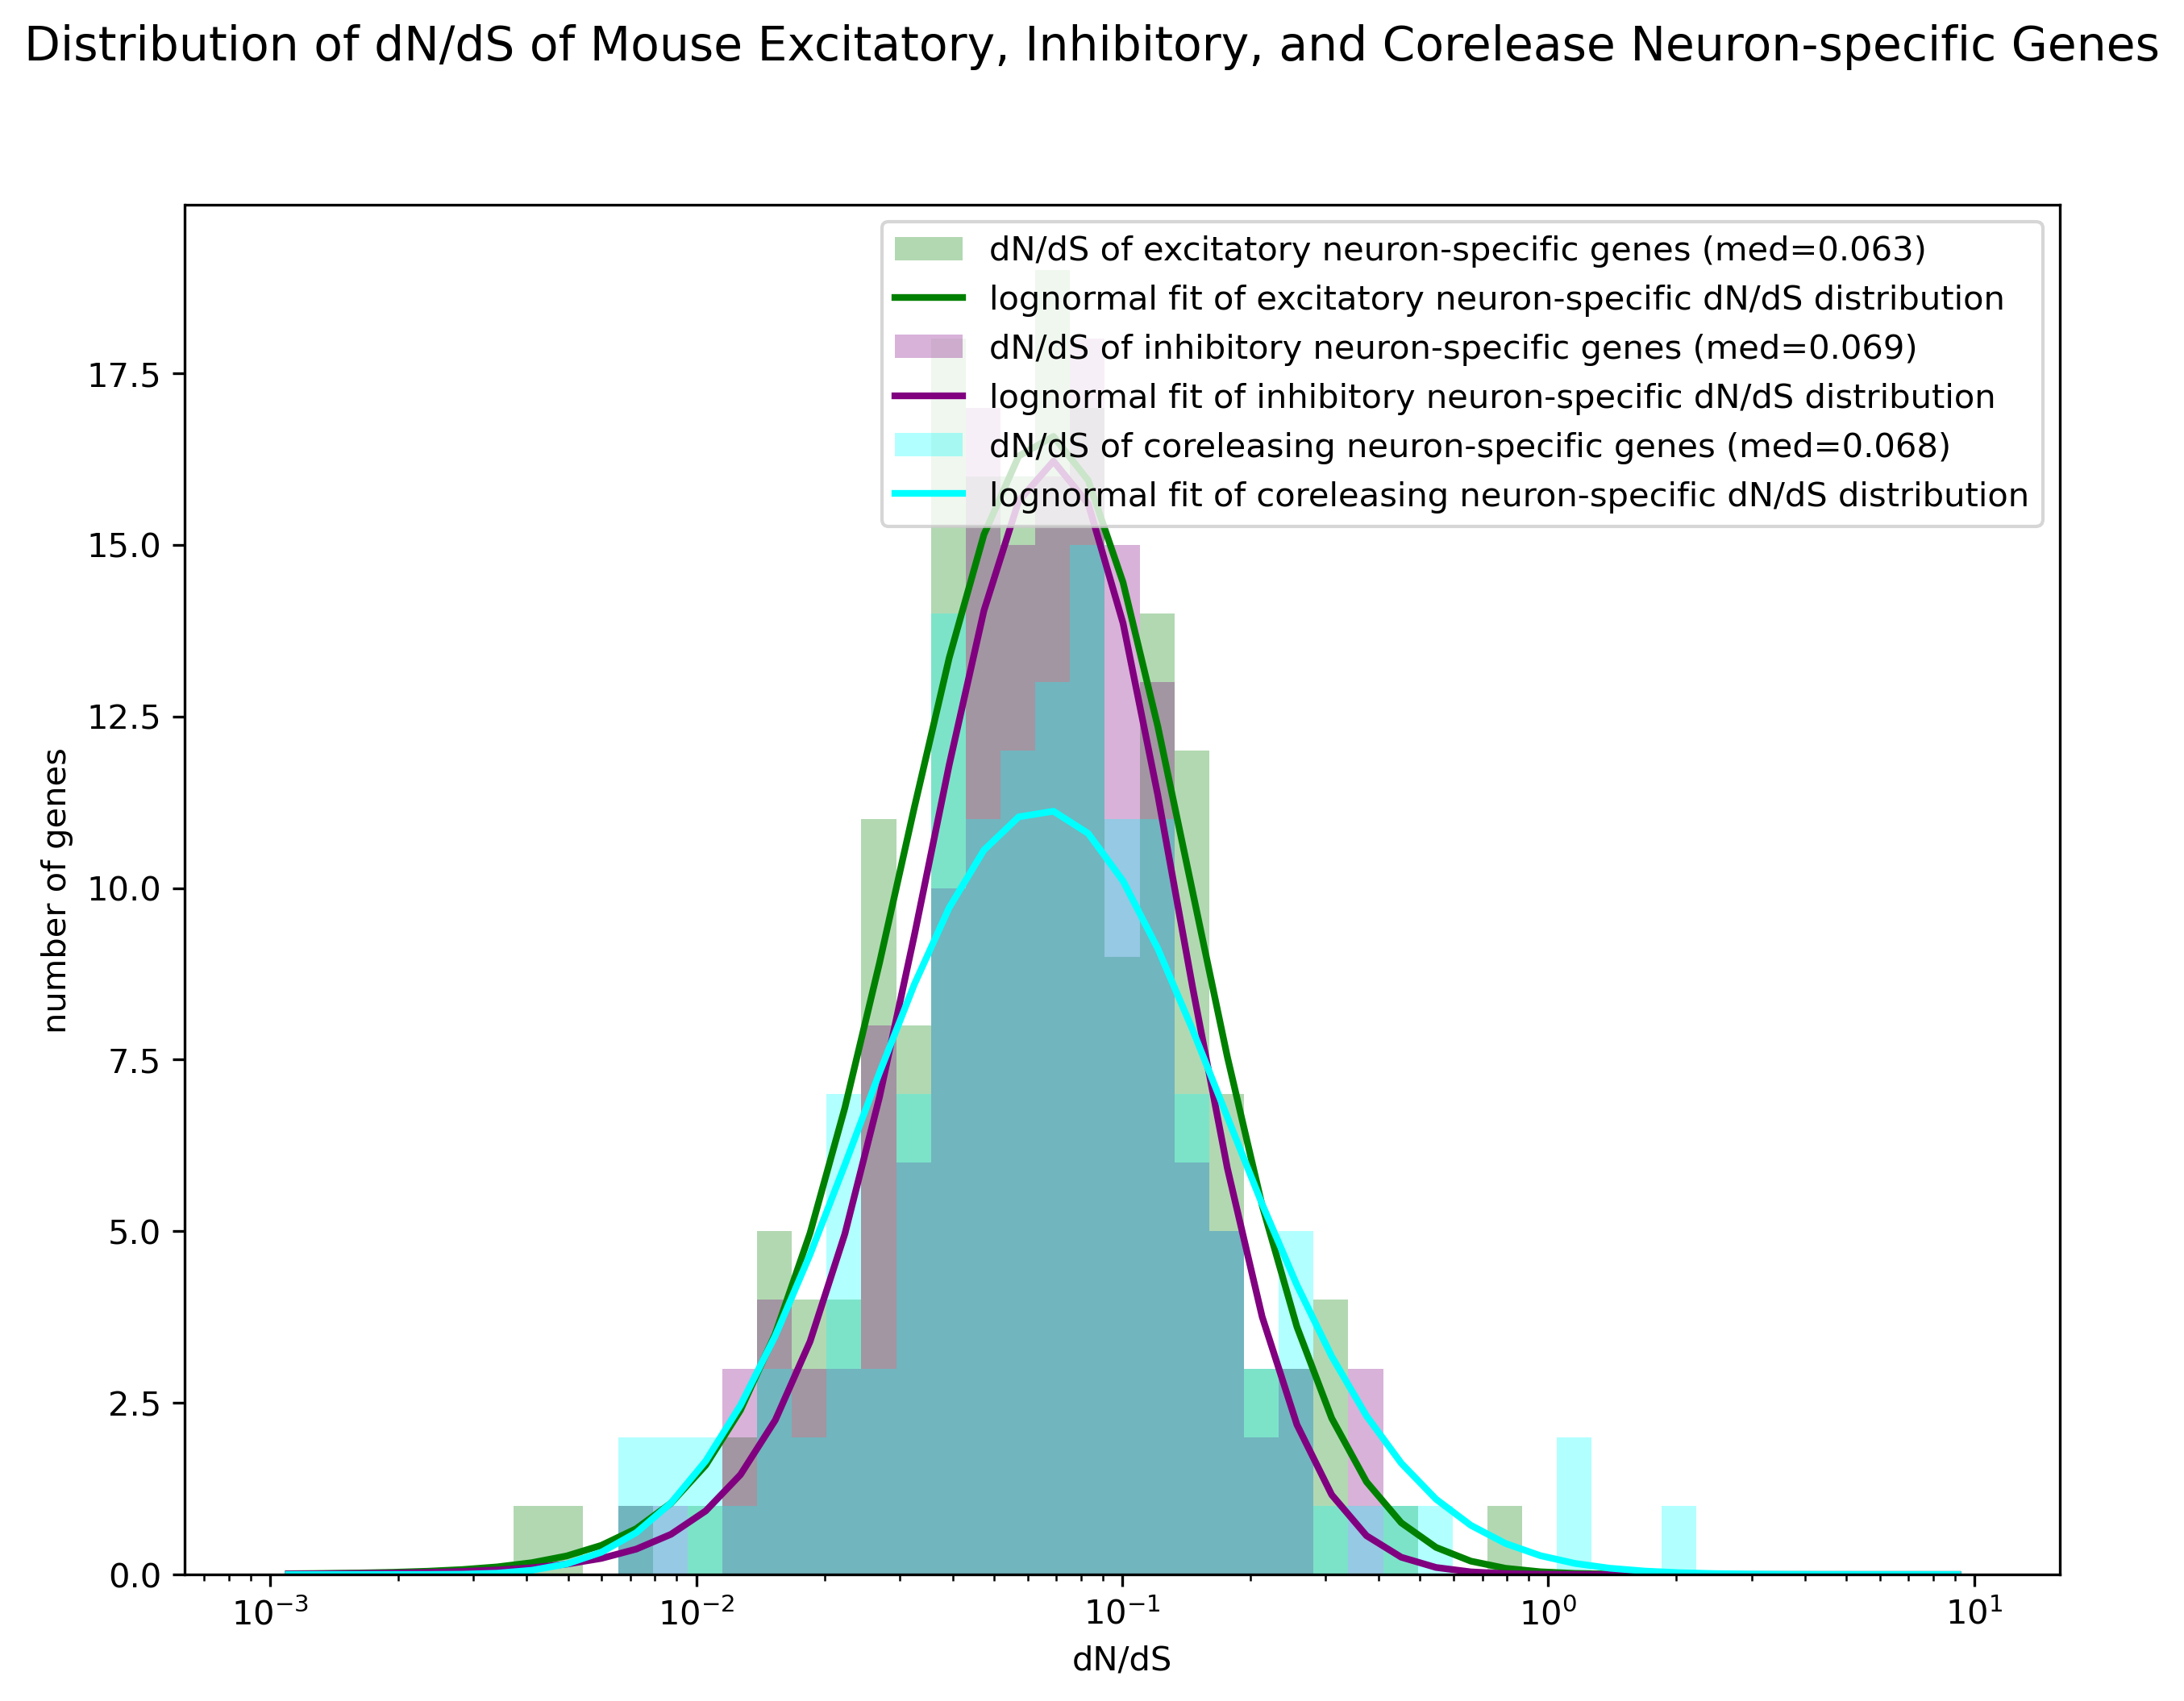

In [38]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
fig.suptitle('Distribution of dN/dS of Mouse Excitatory, Inhibitory, and Corelease Neuron-specific Genes', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
distr_plot = fig.add_subplot(grid[:,:])
#distr_hist = dist_GO_df.plot(ax=distr_plot, kind='hist',alpha=0.3,bins=np.logspace(np.log10(0.001),np.log10(10), 100), logx=True, color=['royalblue','orange','lightgreen'])

# Set up the bins for log scale x-axis, and get the centers
bins=np.logspace(np.log10(0.001),np.log10(10), 50)
bins_cntr = (bins[1:] + bins[:-1]) / 2

color_dict={
    'exc':'green',
    'inh':'purple',
    'both':'cyan',
    # 'nonN':'grey'
}

arr_dict={
    'exc':exc_arr,
    'inh':inh_arr,
    'both':both_arr,
    # 'nonN':nonN_arr
}

name_dict={
    'exc':'excitatory neuron',
    'inh':'inhibitory neuron',
    'both':'coreleasing neuron',
    # 'nonN':'non-neuron'
}

for elec_type in ['exc','inh','both']:
    arr=arr_dict[elec_type]
    counts, bin_edges, ignored = distr_plot.hist(arr,bins,histtype='stepfilled',alpha=0.3,color=color_dict[elec_type],label='dN/dS of '+name_dict[elec_type]+'-specific genes (med={0:.3f})'.format(np.median(arr)))
    try:
        # calculate area of histograms (area under PDF should be 1)
        area_hist = ((bin_edges[1:] - bin_edges[:-1]) * counts).sum()
        shape, loc, scale = stats.lognorm.fit(arr)
        # pdf-values using cdf 
        fit_log_cntr_ = stats.lognorm.cdf(bins, shape, loc=loc, scale=scale)
        fit_log_cntr = np.diff(fit_log_cntr_)
        # plot fitted and scaled PDFs into histogram
        distr_plot.plot(bins_cntr, fit_log_cntr * counts.sum(),color=color_dict[elec_type],linestyle='solid', 
                        label='lognormal fit of '+name_dict[elec_type]+'-specific dN/dS distribution', linewidth=2)
    except ValueError:
        pass

# Axis labels
distr_plot.set_xlabel(xlabel='dN/dS')
distr_plot.set_ylabel(ylabel='number of genes')
distr_plot.set_xscale('log')
distr_plot.legend(loc='best')
# distr_plot.yaxis.set_major_formatter(mtick.PercentFormatter(1))

# fig.savefig('../figures/mouse.organs.pdf')
# fig.savefig('../figures/mouse.organs.eps')
# fig.savefig('../figures/mouse.organs.png')
# plt.close()

In [44]:
pg.mwu(inh_arr,exc_arr,alternative='two-sided')

pg.mwu(both_arr,inh_arr,alternative='two-sided')

pg.mwu(both_arr,exc_arr,alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,13794.0,two-sided,0.75859,-0.019663,0.509831


,U-val,alternative,p-val,RBC,CLES
MWU,11126.0,two-sided,0.725088,-0.023739,0.51187


,U-val,alternative,p-val,RBC,CLES
MWU,13239.0,two-sided,0.535973,-0.040229,0.520115


In [45]:
pg.kruskal(data=exc_inh_merge_df[exc_inh_merge_df['exc_inh_assignment']!='NA'],dv='avg_dNdS',between='exc_inh_assignment')

,Source,ddof1,H,p-unc
Kruskal,exc_inh_assignment,2,0.403942,0.817119
